## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **fully-convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import random
from IPython import display
from sklearn import datasets, preprocessing

In [10]:
torch.manual_seed(239)
np.random.seed(239)

BATCH_SIZE = 4

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.FashionMNIST("./", train=True, transform=transform, download=True)
test_set = torchvision.datasets.FashionMNIST("./", train=False, transform=transform, download=True)
print(train_set.__len__)
print(test_set.__len__)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)
    
    

<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None>
<bound method MNIST.__len__ of Dataset FashionMNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ./
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                         )
    Target Transforms (if any): None>


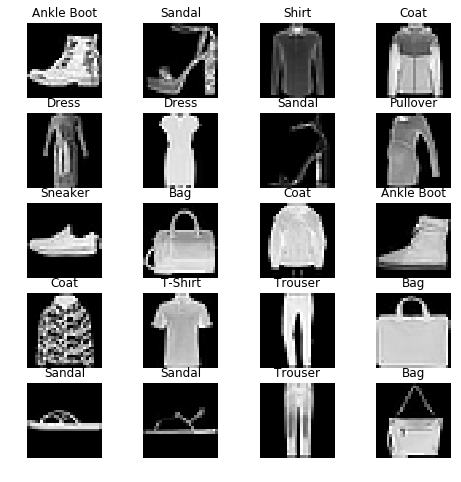

In [11]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns * rows + 1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1].item()])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [12]:
def visualize(acc):
    plt.clf()
    plt.plot(acc)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    plt.ylabel('Accuracy on test_set, %')
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [13]:
def calc_accuracy():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data
        outputs = net(Variable(images))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    return 100 * correct // total


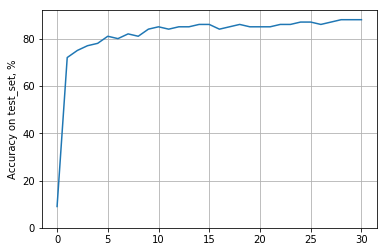

In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 14, 3, padding=1)
        self.fc1 = nn.Linear(14 * 7 * 7, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 14 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_iter = 0
EPOCH_CNT = 2
acc_w = np.zeros(len(train_loader.dataset) * EPOCH_CNT // BATCH_SIZE // 1000 + 1)
for epoch in range(EPOCH_CNT):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = Variable(inputs), Variable(labels)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if n_iter % 1000 == 0:
            acc_w[n_iter // 1000] = calc_accuracy()
            visualize(acc_w)
#             print(n_iter, acc_w[n_iter // 1000])
#             print(f"Loss = {loss.item()}")
        n_iter += 1

print('Finished Training')
acc_w[-1] = calc_accuracy()
visualize(acc_w)
plt.clf()

In [15]:
print('Accuracy = %d %%' % calc_accuracy())

Accuracy = 88 %
